In [94]:
# -*- coding:utf-8 -*-
import sys
import csv
import math
import datetime

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle

import cv2
from PIL import Image

import os

import tdclient
import pandas_td as td
 
import google.cloud.storage
from google.cloud import storage

%matplotlib inline


In [95]:
#メソッド

#座標補正メソッド
def corrected_data(line):
    xy_lst = []
    #　小数点以下切り上げ
    #line[1] = math.ceil(float(line[1]))
    #line[2] = math.ceil(float(line[2]))
    x = math.ceil(float(line[2]))
    y = math.ceil(float(line[3]))
    
    #x軸補正
    #if line[1] < 0:
    if x < 0:    
        #xy_lst.append(line[1]*(-1) + 90)
        xy_lst.append(x*(-1) + 90)
    else:
        #xy_lst.append((line[1] - 90)*(-1))
        xy_lst.append((x - 90)*(-1))
     #補正無しX軸   
    #xy_lst.append(line[1])
    
    #y軸補正
    #fix_y = line[2] + 180
    fix_y = y + 180
    if fix_y > 360 :
        xy_lst.append(fix_y - 360)
    else:
        xy_lst.append(fix_y)
    return xy_lst

#余白削除メソッド
def margin_cut(file_name='./hm.jpg',output_name='./hm_edge.png'):
    filename = file_name #'./image_3453421.jpg'
    img = cv2.imread(filename)
    img2 = cv2.imread(filename)

    # Grayscale に変換
    img_gs = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 2 値化
    ret, thresh = cv2.threshold(img_gs, 250, 255, cv2.THRESH_BINARY)

    # 輪郭を取得
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # i = 1 は画像全体の外枠になるのでカウントに入れない
    x1 = []
    y1 = []
    x2 = []
    y2 = []
    for i in range(1, len(contours)):
        # ret の中身は (x, y, w, h)
        ret = cv2.boundingRect(contours[i])
        x1.append(ret[0])
        y1.append(ret[1])
        x2.append(ret[0] + ret[2])
        y2.append(ret[1] + ret[3])

    x1_min = min(x1)
    y1_min = min(y1)
    x2_max = max(x2)
    y2_max = max(y2)

    # 枠取りをした結果を表示
    #cv2.rectangle(img, (x1_min, y1_min), (x2_max, y2_max), (0, 255, 0), 2)
    #cv2.imwrite('cropped_edge_rectangle.jpg', img)

    # ギリギリで切り出し
    crop_img = img2[y1_min:y2_max, x1_min:x2_max]
    cv2.imwrite(output_name, crop_img)

#GCSからの画像データダウンロード
def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    # bucket_name = "your-bucket-name"
    # source_blob_name = "storage-object-name"
    # destination_file_name = "local/path/to/file"

    storage_client = storage.Client()

    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)

    print(
        "Blob {} downloaded to {}.".format(
            source_blob_name, destination_file_name
        )
    ) 

#item_idかmdia_idかで実行するsqlを変える
def sql_selecter(val,num):
    if val == 'item_id':
        sql1 = "SELECT id as media_id, item_id ,x ,y FROM panorama_user_event t1 \
        JOIN ( SELECT id, mediumable_id FROM nurvecloud.media WHERE mediumable_type = 'Item' ) t2 \
        ON mediumable_id = item_id WHERE item_id ="
        sql2 = " AND x IS NOT NULL AND y IS NOT NULL ORDER BY time"
        sql = sql1 + num + sql2
    else:
        sql1 = "SELECT id as media_id, item_id ,x ,y FROM panorama_user_event t1 \
        JOIN ( SELECT id, mediumable_id FROM nurvecloud.media WHERE mediumable_type = 'Item' ) t2 \
        ON mediumable_id = item_id WHERE id ="
        sql2 = " AND x IS NOT NULL AND y IS NOT NULL ORDER BY time"
        sql = sql1 + num + sql2
    return sql

#ヒートマップデータ作成
def data_maker(*axis_data_lst):
    lst_2d = [] #ヒートマップデータ配列
    x_ranges = [] #x軸bin範囲配列
    x_cnt = [] #x軸bin配列

    #x軸範囲設定
    i = 0
    for x in range(0,360,18):
        x_cnt.append(i)
        x_ranges.append(x)
        i += 1
    
    #x軸データ管理配列設定   
    x_length = len(x_cnt)    

    #x:yデータ集計
    for i in range(0,180,10):
        x_lst = [0] * x_length #x_lstを0初期化
        for xy in  axis_data_lst:
            x = xy[0]
            if x >= i and x < i + 10:
                for cnt, x_range in zip(x_cnt, x_ranges):
                    if xy[1] >= x_range and xy[1] < x_range + 18:
                            x_lst[cnt] += 1
        lst_2d.append(x_lst)
    return lst_2d

#v_max設定
def v_max_set(*lst_2d):
    x_min = 1000
    x_max = 0
    for xs in lst_2d:
        for x in xs:
            if x_max < x:
                x_max = x
            if x_min > x:
                x_min = x

    # vのレンジ幅の設定            
    if x_max >= 150:
        v_max = x_max
    elif x_max >= 100:
        v_max = 100
    elif x_max >= 50:
        v_max = 50
    elif x_max >= 25:
        v_max = 15
    elif x_max >= 5:
        v_max = 5
    else:
        v_max = x_max
    return v_max

In [149]:
#いずれはコマンド入力へ変更
val = 'item_id'
file = '2037861' #item_id
#val = 'media_id'
#file = '15122174'
#media_id = '13106716'

In [150]:
#TDから直接座標データ吸い取り
print('TDからデータ取り込み開始')
# Initialize query engine
engine = td.create_engine('presto:rails_events_production')

# Read Treasure Data query into a DataFrame.
sql = sql_selecter(val,file)
df = td.read_td(sql, engine)

In [151]:
lines = df.values.tolist()
print('データ取り込み完了')

データ取り込み完了


In [152]:
#読み込み画像データ設定
line = lines[0]
file = str(int(line[1])) #item_id
media_id = str(int(line[0])) #media_id

print('item_id:{}/media_id:{}'.format(file,media_id))

item_id:2037861/media_id:3633097


In [153]:
#座標補正処理 Ver02
axis_data_lst = []
f_lst = []
idx = 0
for line in lines:    
    data = corrected_data(line) #座標補正
    axis_data_lst.append(data)
print('座標補正完了')

座標補正完了


In [154]:
#ヒートマップデータ作成Ver02
lst_2d = data_maker(*axis_data_lst)
print('ヒートマップデータ作成完了')

ヒートマップデータ作成完了


In [155]:
# vのレンジ幅の調整
v_max = v_max_set(*lst_2d)
print('vmax:{}'.format(v_max))

vmax:208


凡例付きヒートマップ作成完了


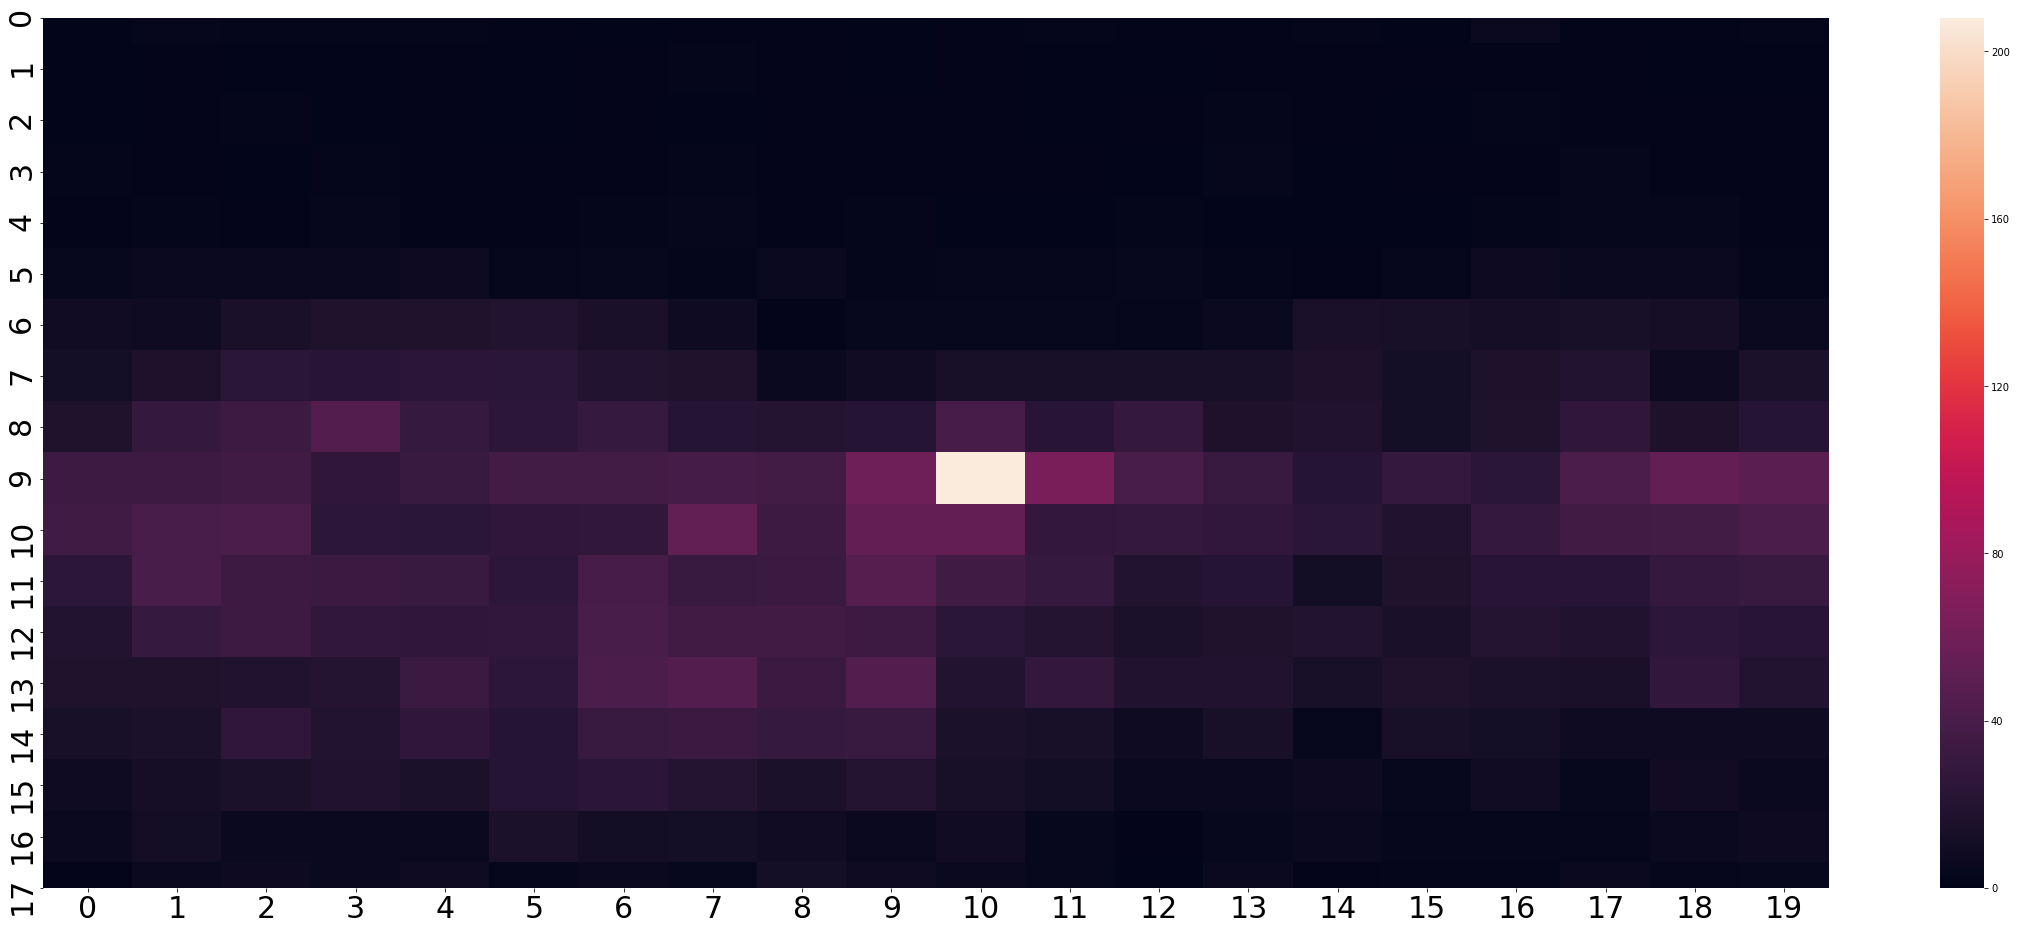

In [156]:
#凡例付きヒートマップ作成
hm_name = "./tmp/hm_org.jpg"
colorbar = True
plt.figure(figsize=(40,16)) 
#fig, ax = plt.subplots(figsize=(32,16))
plt.tick_params(labelsize=30)
sns.heatmap(lst_2d,vmin=0, vmax=v_max)
#sns.heatmap(lst_2d,vmin=0, vmax=5)
plt.savefig(hm_name_sample )
print('凡例付きヒートマップ作成完了')

合成用ヒートマップ作成完了


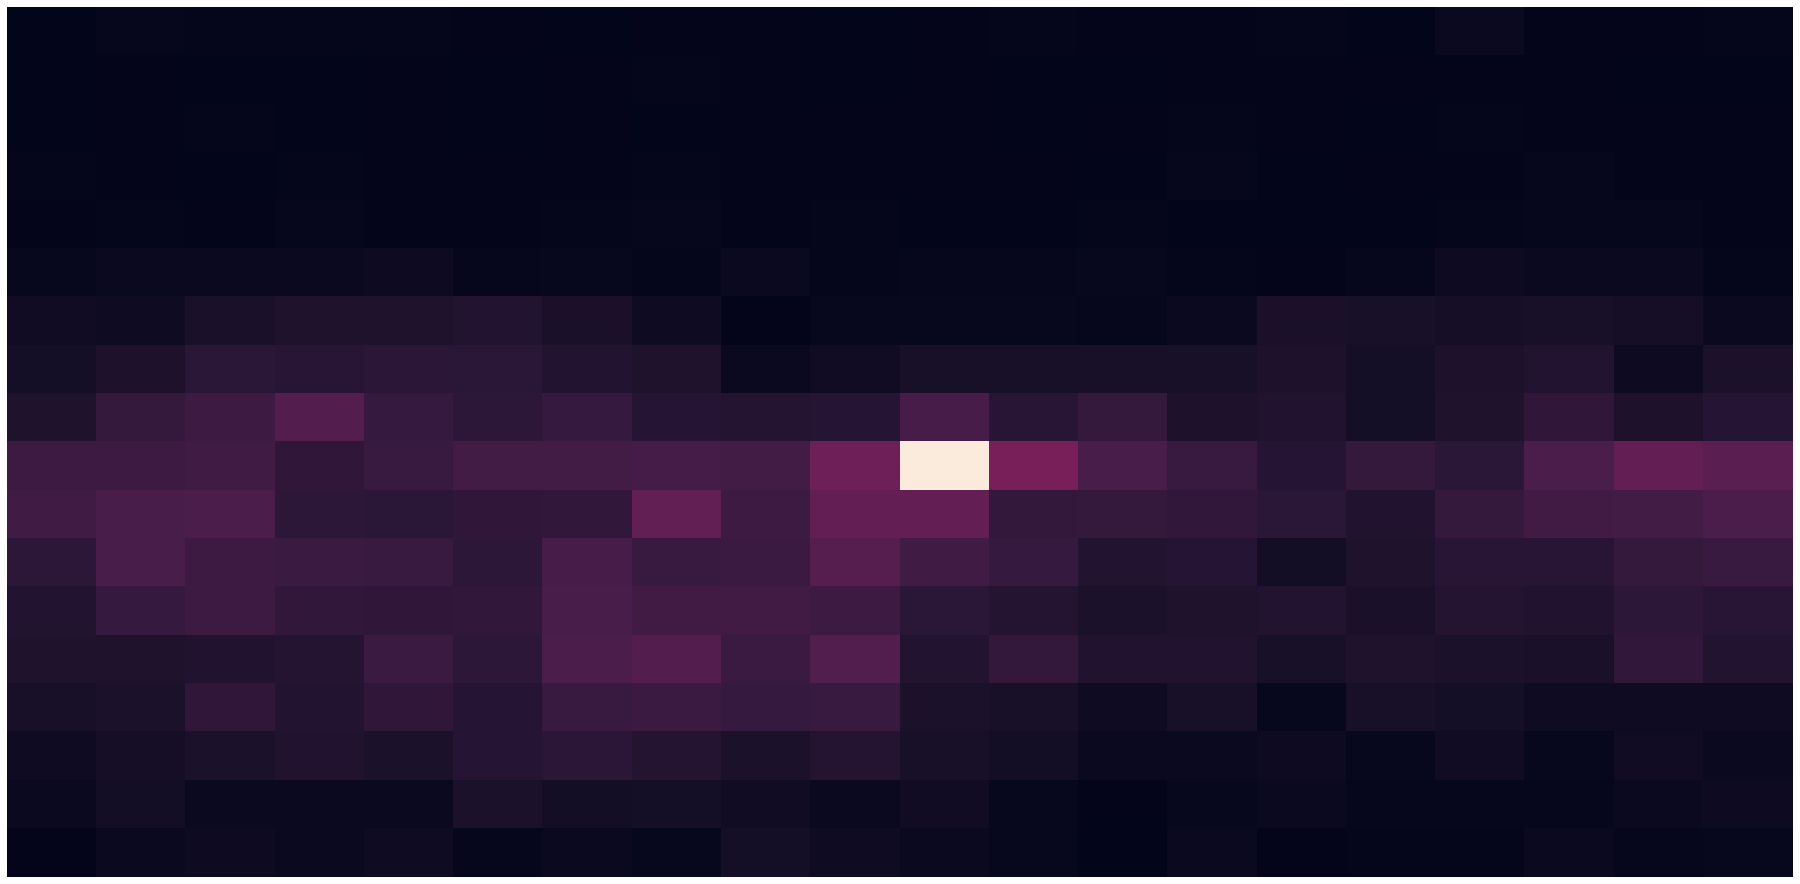

In [157]:
#合成用ヒートマップ作成
hm_name = "./tmp/hm.jpg" #<- dirをつける
plt.figure(figsize=(32,16)) 
sns.heatmap(lst_2d,vmin=0, vmax=v_max,yticklabels=False,xticklabels=False,cbar=False)
plt.savefig(hm_name )
print('合成用ヒートマップ作成完了')

In [158]:
#削除対象
#HM原画サイズ確認
filename = hm_name
img2 = cv2.imread(filename)
height = img2.shape[0]
width = img2.shape[1]
print('h:{}/w{}'.format(height,width))

h:1152/w2304


In [159]:
#HM余白削除
outfile = './tmp/hm_edge.jpg'
#outfile = margin_cut(hm_name,outfile)
margin_cut(hm_name,outfile)
print('余白削除処理完了')

余白削除処理完了


In [160]:
#CDSバケット内リスト取得
def list_blobs(bucket_name):
        """Lists all the blobs in the bucket."""
        # bucket_name = "your-bucket-name"

        storage_client = storage.Client()

        # Note: Client.list_blobs requires at least package version 1.17.0.
        blobs = storage_client.list_blobs(bucket_name)

        for blob in blobs:
            print(blob.name)

In [161]:
from google.cloud import storage
import re

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/tani_kyuichiro/nurve-cloud-98b3f-bb7c97f8fb03.json'
bucket_name = 'rent-production'
prefix = 'medium_items/media/'+media_id + '/'
def extension_get(bucket_name,prefix):
    storage_client = storage.Client()

        # Note: Client.list_blobs requires at least package version 1.17.0.
    blobs = storage_client.list_blobs(
            bucket_name, prefix=prefix, delimiter='/'
        )

    blob_lst = []
    target = prefix+'2048x1024.'

    for blob in blobs:
        blob_lst.append(blob.name)
    l_in = [s for s in blob_lst if target in s] 

    if len(l_in) > 0:
        extension = l_in[0].replace(target,'')
        return extension
    else:
        False
    
    


In [162]:
#直接画像読み込み
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/tani_kyuichiro/nurve-cloud-98b3f-bb7c97f8fb03.json'

#bucket_name = 'rent-production/medium_items/media/'+media_id
bucket_name = 'rent-production'
source_blob_name = 'medium_items/media/'+media_id + '/2048x1024.jpg'
file_name = './imgdata/2048x1024.jpg'
download_blob(bucket_name,source_blob_name,file_name)
print('オリジナル画像読み込み完了')

Blob medium_items/media/3633097/2048x1024.jpg downloaded to ./imgdata/2048x1024.jpg.
オリジナル画像読み込み完了


In [163]:
#画像データ読み込み
filename = './imgdata/2048x1024.jpg'
try:
    img = cv2.imread(filename)
    height = img.shape[0] # Errorを引っ掛けるためだけの仕掛
except  AttributeError:
    print('file not found. {}'.format(filename))

In [164]:
#削除対象
#item画像サイズ確認
height = img.shape[0]
width = img.shape[1]
print('h:{}/w{}'.format(height,width))

h:1024/w2048


In [165]:
#余白除去後HM読み込み
filename = './tmp/hm_edge.jpg' # <- dirをつける
try: 
    img2 = cv2.imread(filename)
    height = img2.shape[0] # Errorを引っ掛けるためだけの仕掛
except  AttributeError:
    print('file not found.')

In [166]:
#削除対象
height = img2.shape[0]
width = img2.shape[1]
print('h:{}/w{}'.format(height,width))

h:872/w1792


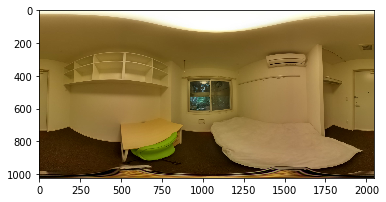

In [167]:
#削除対象
#画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
plt.show()

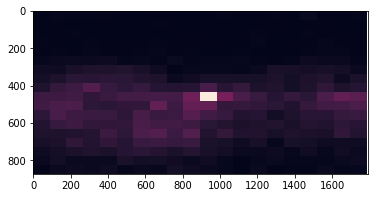

In [168]:
#削除対象
#filename = 'hm_7306642_edge.jpg'
#img2 = cv2.imread(filename)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
plt.show()

In [169]:
#サイズ設定読み込み
height = img2.shape[0]
width = img2.shape[1]
print(img2.shape)

(872, 1792, 3)


In [170]:
#サイズ調整
img2_1 = cv2.resize(img2 , (int(width*(2048.5/width)), int(height*(1024/height))))
print(img2_1.shape)
print('ヒートマップのサイズ調整完了')
#cv2.imwrite('./tmp/hm_edge.jpg', img2_1)

(1024, 2048, 3)
ヒートマップのサイズ調整完了


In [171]:
#img2 = Image.open('hm_edge.jpg')

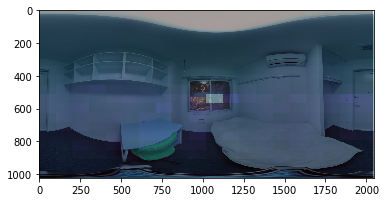

In [172]:
#画像合成
blended = cv2.addWeighted(src1=img,alpha=0.6,src2=img2_1,beta=0.4,gamma=0.3)
plt.imshow(blended)

In [173]:
#合成後画像保存
cv2.imwrite('./tmp/blended_test.jpg', blended) # <- dirをつける
print('合成画像作成完了')

合成画像作成完了


In [174]:
#凡例切り出し準備
im = Image.open(hm_name_sample)

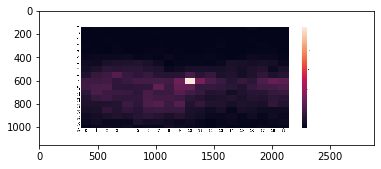

In [175]:
plt.imshow(im)

凡例作成完了


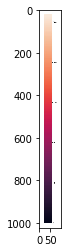

In [176]:
#凡例切り出し&resize
im_crop = im.crop((2230,120,2350,1030))
im_crop_rsize = im_crop.resize((100,1024))   
plt.imshow(im_crop_rsize)
im_crop_rsize.save('./tmp/colorbar_crop.jpg', quality=100) # <- dirをつける
print('凡例作成完了')

In [177]:
#ブランク画像作成
height = 1024
width = 2200
blank = np.zeros((height, width, 3))
blank += 255 #←全ゼロデータに255を足してホワイトにする
 
cv2.imwrite('./tmp/blank.jpg',blank) # <- dirをつける
print('ベース画像作成完了')

ベース画像作成完了


In [178]:
#凡例付きヒートマップ作成
img0 = cv2.imread('./tmp/blank.jpg') # <- dirをつける
img1 = cv2.imread('./tmp/blended_test.jpg') # <- dirをつける
img2 = cv2.imread('./tmp/colorbar_crop.jpg') # <- dirをつける

img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

base_img = img0


In [179]:
#ヒートマップ画像貼り付け基準点設定
x_offset=0
y_offset=0

In [180]:
#ヒートマップ画像合成
base_img[y_offset:y_offset+img1.shape[0], x_offset:x_offset+img1.shape[1]] = img1

In [181]:
#凡例画像貼り付け基準点設定
x_offset=2050
y_offset=0

In [182]:
#凡例画像合成
base_img[y_offset:y_offset+img2.shape[0], x_offset:x_offset+img2.shape[1]] = img2

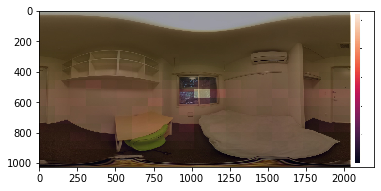

In [183]:
#削除対象
plt.imshow(base_img)

In [184]:
base_img = cv2.cvtColor(base_img, cv2.COLOR_BGR2RGB)

media_dir = './medium_items/media/' + media_id 

if not os.path.exists(media_dir):
    os.makedirs(media_dir) #dirが無い場合作成

dir_file_name = './medium_items/media/' + media_id + '/heatmap.jpg'

cv2.imwrite(dir_file_name,base_img)
print('凡例付き合成画像作成完了')

凡例付き合成画像作成完了


In [185]:
#GCSへのアップロード
# Create a storage client.

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/tani_kyuichiro/nurve-cloud-98b3f-bb7c97f8fb03.json'

storage_client = google.cloud.storage.Client()

bucket_name = 'rent-heatmap' 
bucket = storage_client.get_bucket(bucket_name)

source_file_name = 'medium_items/media/' + media_id + '/heatmap.jpg'
blob = bucket.blob(source_file_name)
 
# Upload the local file to Cloud Storage.
blob.upload_from_filename(source_file_name)
 
print('File {} uploaded to {}.'.format(source_file_name,bucket))
print('GCSへのアップロード完了')

File medium_items/media/3633097/heatmap.jpg uploaded to <Bucket: rent-heatmap>.
GCSへのアップロード完了
